<a href="https://colab.research.google.com/github/YuhuiRainie/graduateProject/blob/master/plantVillage1024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from torchvision.models import resnet101
from torchvision.utils import make_grid

%matplotlib inline
plt.style.use('default')

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [22]:
# Download the dataset and unzip de folder
!gdown https://drive.google.com/uc?id=1n88feRxHo7bk0e5v02U9pK6gOJgWYQZw



Downloading...
From: https://drive.google.com/uc?id=1n88feRxHo7bk0e5v02U9pK6gOJgWYQZw
To: /content/PlantVillage.rar
850MB [00:04, 183MB/s]


In [23]:
!pip install patool
import patoolib

     |████████████████████████████████| 81kB 2.5MB/s 


In [24]:
patoolib.extract_archive("PlantVillage.rar")

patool: Extracting PlantVillage.rar ...
patool: running /usr/bin/unrar x -- /content/PlantVillage.rar
patool:     with cwd='./Unpack_ozypyf3f'
patool: ... PlantVillage.rar extracted to `PlantVillage'.


'PlantVillage'

In [0]:
data_dir = 'PlantVillage'

In [27]:
# check path
os.path.isdir(data_dir)
# os.path.isfile(data_dir)

True

In [0]:
!ls PlantVillage

In [0]:
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# TODO: Load the datasets with ImageFolder
print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
# dataloaders = 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

Initializing Datasets and Dataloaders...


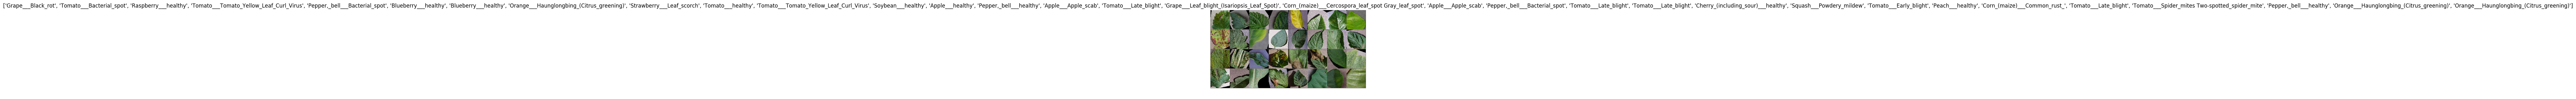

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = make_grid(inputs)
plt.axis('off')

imshow(out, title=[class_names[x] for x in classes])

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [29]:
!gdown https://drive.google.com/uc?id=1sApr-glodBavRJYzI_YJ1d9OGIr0S6cV

Downloading...
From: https://drive.google.com/uc?id=1sApr-glodBavRJYzI_YJ1d9OGIr0S6cV
To: /content/categories.json
100% 2.20k/2.20k [00:00<00:00, 1.92MB/s]


In [0]:
path_json = ('categories.json')

In [0]:
import json

with open(path_json, 'r') as f:
    label_map = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
from torchvision import datasets, transforms, models

In [3]:
# TODO: Build and train your network
model = models.resnet152(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:04<00:00, 58.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
# freeze the parameters of model
for param in model.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have gradients calculated
num_ftrs = model.fc.in_features  # it's 2048, check fc layer of resnet
    
# make our own classifier
# class Classifier(nn.Module):
#     def __init__(self, num_ftrs):
#         super().__init__()
#         self.fc1 = nn.Linear(num_ftrs, 512)
#         self.fc2 = nn.Linear(512, 102)
#         self.dropout = nn.Dropout(0.2)
    
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2)
#         return x
# classifier = Classifier(num_ftrs)

classifier = nn.Sequential(nn.Linear(num_ftrs, 512),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512, 38))

# replace model's classifer (fc layer) with ours
# model.classifier = classifier
model.fc = classifier
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
def train(model, criterion, optimizer, scheduler, epochs=1):
    """Trains the model and calculate train and validation loss and accuracy"""
    
    since = time.time()

    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f'Epoch: {epoch+1}/{epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 # TODO: Save the checkpoint 
#                 model.class_to_idx = image_datasets['train'].class_to_idx
#                 model.cpu()
#                 model.epochs = epochs
#                 checkpoint = {'input_size': [3, 224, 224],
#                                  'batch_size': dataloaders['train'].batch_size,
#                                   'output_size': 39,
#                                   'state_dict': model.state_dict(),
#                                   'data_transforms': data_transforms,
#                                   'optimizer_dict':optimizer.state_dict(),
#                                   'class_to_idx': model.class_to_idx,
#                                   'epoch': model.epochs}
#                 torch.save(checkpoint, 'plants_checkpoint.pth')
#                 # for saving to google drive
#                 from google.colab import drive
#                 drive.mount('/content/gdrive')
#                 model_save_name = 'classifier_resnet152.pth'
#                 path = f'/content/{model_save_name}' 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
train(model, criterion, optimizer, scheduler, epochs=20)

Epoch: 1/20
----------
train Loss: 0.8685 Acc: 0.7505
val Loss: 0.2864 Acc: 0.9062

Epoch: 2/20
----------
train Loss: 0.5253 Acc: 0.8360
val Loss: 0.2536 Acc: 0.9149

Epoch: 3/20
----------
train Loss: 0.4806 Acc: 0.8483
val Loss: 0.2293 Acc: 0.9234

Epoch: 4/20
----------
train Loss: 0.4601 Acc: 0.8559
val Loss: 0.2316 Acc: 0.9244

Epoch: 5/20
----------
train Loss: 0.4395 Acc: 0.8583
val Loss: 0.1895 Acc: 0.9376

Epoch: 6/20
----------
train Loss: 0.4274 Acc: 0.8664
val Loss: 0.1987 Acc: 0.9335

Epoch: 7/20
----------
train Loss: 0.3140 Acc: 0.8977
val Loss: 0.1245 Acc: 0.9580

Epoch: 8/20
----------
train Loss: 0.2926 Acc: 0.9047
val Loss: 0.1291 Acc: 0.9571

Epoch: 9/20
----------
train Loss: 0.2901 Acc: 0.9081
val Loss: 0.1290 Acc: 0.9568

Epoch: 10/20
----------
train Loss: 0.2845 Acc: 0.9087
val Loss: 0.1169 Acc: 0.9599

Epoch: 11/20
----------
train Loss: 0.2856 Acc: 0.9090
val Loss: 0.1172 Acc: 0.9598

Epoch: 12/20
----------
train Loss: 0.2715 Acc: 0.9135
val Loss: 0.1215 Ac

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [0]:
# plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

NameError: ignored

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

![key_map.png](https://github.com/kHarshit/transfer-learning/blob/master/assets/key_map.png?raw=1)

In [0]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'state_dict': model.state_dict(),
           'class_to_idx': model.class_to_idx,
           'optimizer_state_dict': optimizer.state_dict()},
          'classifier_resnet101.pth')

In [0]:
# for saving to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_save_name = 'classifier_resnet101.pth'
path = f'/content/gdrive/My Drive/{model_save_name}' 
torch.save({'state_dict': model.state_dict(),
           'class_to_idx': model.class_to_idx,
           'optimizer_state_dict': optimizer.state_dict()},
          path)
# checkpoint = {'input_size': [3, 224, 224],
#                  'batch_size': dataloaders['train'].batch_size,
#                   'output_size': 39,
#                   'state_dict': model.state_dict(),
#                   'data_transforms': data_transforms,
#                   'optimizer_dict':optimizer.state_dict(),
#                   'class_to_idx': model.class_to_idx}
# torch.save(checkpoint, 'plants9615_checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [4]:
!gdown https://drive.google.com/uc?id=18ZEwBA9fLuLy6Gk2rK-xQwM9F6tQ_24g

Downloading...
From: https://drive.google.com/uc?id=18ZEwBA9fLuLy6Gk2rK-xQwM9F6tQ_24g
To: /content/classifier_resnet152.pth
246MB [00:01, 175MB/s]


In [5]:
# check if saved classifier is present
os.path.isfile('classifier_resnet152.pth')

True

In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 38
    
    classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512, 38))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('classifier_resnet152.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
from PIL import Image
from torch.autograd import Variable
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [16]:
print (predict('/content/drive/My Drive/b0be11.jpg', loaded_model))

(array([245.93361  , 244.12692  ,  75.082985 ,  17.204899 ,   2.5305057],
      dtype=float32), ['Strawberry___Leaf_scorch', 'Peach___Bacterial_spot', 'Grape___Esca_(Black_Measles)', 'Grape___Black_rot', 'Tomato___Early_blight'])


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
#     img_filename = img.split('/')[-2]
#     print(img_filename)
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
#     flower_name = mapper[img_filename]
    
#     ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

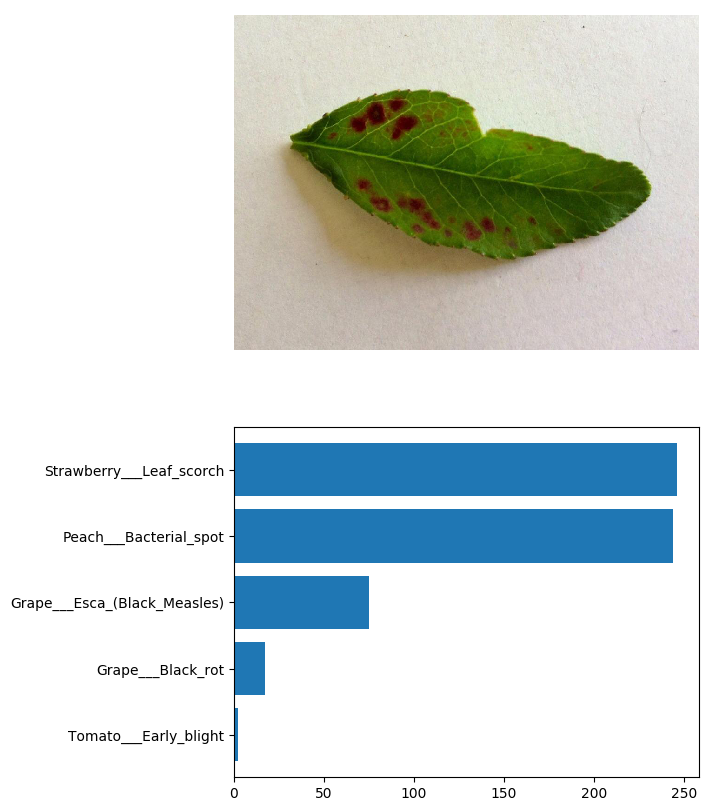

In [35]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
# img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
# img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
# img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
img = '/content/drive/My Drive/b0be11.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, label_map)

In [0]:
# TODO: Display an image along with the top 5 classes